In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import copy
import os

In [3]:
#load images
left, right = glob.glob("mynteye/left*.png"), glob.glob("mynteye/right*.png")

In [4]:
#set parameters of objects matrix
row, col = 6, 9
objp = np.zeros((row*col, 3), np.float32)
objp[:,:2] = np.mgrid[0:col, 0:row].T.reshape(-1,2)
#store objects coordinate and 2D points coordinate
obj = []
impl= []
impr = []

for imgl, imgr in zip(left, right):
    #Left load each image and find corners
    imgL = cv2.imread(imgl)
    retl, corners_l = cv2.findChessboardCorners(imgL, (col, row))
    im_l = copy.deepcopy(imgL)
    cv2.drawChessboardCorners(im_l, (col,row), corners_l, retl)
    #Right load each image and find corners
    imgR = cv2.imread(imgr)
    retr, corners_r = cv2.findChessboardCorners(imgR, (col,row))
    im_r = copy.deepcopy(imgR)
    cv2.drawChessboardCorners(im_r, (col,row), corners_r, retr)
    #sotre size of pictures
    h, w = imgR.shape[:2]
    #show pictures
    cv2.imshow('left', im_l)
    cv2.imshow('right', im_r)
    cv2.waitKey(500)
    #store corresponding points coordinats in world frame and image frame
    if retl == True & retr == True:
        obj.append(objp)
        impl.append(corners_l)
        impr.append(corners_r)

cv2.destroyAllWindows()
#calibration
retl, mtxl, distl, rvecsl, tvecsl = cv2.calibrateCamera(obj, impl, (w,h), None, None)
retr, mtxr, distr, rvecsr, tvecsr = cv2.calibrateCamera(obj, impr, (w,h), None, None)

In [5]:
#create array for undistorted images
dstL = []
dstR = []

for l, r in zip(left, right):
    l = cv2.imread(l)
    r = cv2.imread(r)
    
    dst_l = cv2.undistort(l, mtxl, distl)
    dst_r = cv2.undistort(r, mtxr, distr)
    
    dstL.append(dst_l)
    dstR.append(dst_r)

In [6]:
#for stereo calibration
#set flags
flags = 0
flags |= cv2.CALIB_FIX_ASPECT_RATIO
flags |= cv2.CALIB_ZERO_TANGENT_DIST
flags |= cv2.CALIB_SAME_FOCAL_LENGTH
flags |= cv2.CALIB_RATIONAL_MODEL
flags |= cv2.CALIB_FIX_K3
flags |= cv2.CALIB_FIX_K4
flags |= cv2.CALIB_FIX_K5
#set criteria
cri = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-5)
#calibration
ret, mtxl, distl, mtxr, distr, R, T, E, F = cv2.stereoCalibrate(obj, impl, impr, mtxl, distl, mtxr, distr, 
                                                                (w,h), 
                                                                criteria = cri, 
                                                                flags = flags)

In [7]:
#recitfy 
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(mtxl, distl, mtxr, distr, (w,h), R, T)

In [ ]:
#store data
np.save(r".\R1.npy", R1)
np.save(r".\R2.npy", R2)
np.save(r".\P1.npy", P1)
np.save(r".\P2.npy", P2)
np.save(r".\matrix of left.npy", mtxl)
np.save(r".\matrix of right.npy", mtxr)
np.save(r".\matrix of distorted coefficients of left.npy", distl)
np.save(r".\matrix of distorted coefficients of right.npy", distr)
np.save(r".\width and height of image.npy", (w, h))

In [8]:
#find projects relationship
mapl1, mapl2 = cv2.initUndistortRectifyMap(mtxl, distl, R1, P1, (w,h), cv2.CV_32FC1)
mapr1, mapr2 = cv2.initUndistortRectifyMap(mtxr, distr, R2, P2, (w,h), cv2.CV_32FC1)

In [9]:
#load images and recify them
im_l = cv2.imread(left[0])
im_r = cv2.imread(right[0])

im__l = cv2.remap(im_l, mapl1, mapl2, cv2.INTER_LINEAR)
im__r = cv2.remap(im_r, mapr1, mapr2, cv2.INTER_LINEAR)

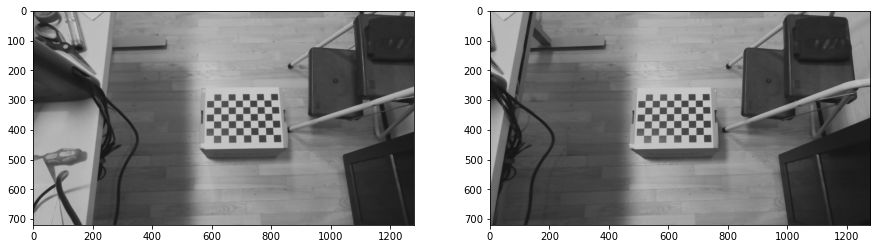

In [11]:
#show them
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(im__l)
plt.subplot(1,2,2)
plt.imshow(im__r)